## Import modules

In [24]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import gc
import joblib # Use to save model
from datetime import datetime, timezone
from sklearn.metrics import classification_report
sns.set()

In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_11_04T18_57_L001_cylinder_r_0_1_grid_0_02_features.npz"""
ROOT_2  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_11_04T19_28_L001_cylinder_r_0_2_grid_0_04_features.npz"""
ROOT_3  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_11_04T20_25_L001_cylinder_r_0_4_grid_0_08_features.npz"""
ROOT_4  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_11_04T20_56_L001_cylinder_r_0_8_grid_0_16_features.npz"""
ROOT_5  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_11_05T03_08_L001_cylinder_r_1_6_grid_0_32_features.npz"""
ROOT_6 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_11_05T03_49_L001_cylinder_r_3_2_grid_0_64_features.npz"""
# ROOT_7 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T00_29_L001_r_6_4_grid_1_28_features.npz"""
# ROOT_8 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T01_37_L001_r_12_8_grid_2_56_features.npz"""


In [4]:
fileList = [ROOT,ROOT_2, ROOT_3,ROOT_4,ROOT_5, ROOT_6]

## Get computed features

In [5]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

## Load in points and labels

In [6]:
xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

## Combine road markings with Ground points

In [7]:
cls[cls==2] = 1

In [8]:
cls[cls > 1] -= 1

## Get columns

In [9]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","count"]

In [10]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [11]:
allCols = ['X', 'Y','Z'] + ff + ['label']

In [12]:
allAtrs = np.hstack((xyz,das, cls.reshape(-1, 1)))

## Create dataframe

In [13]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [14]:
gc.collect()

108

In [15]:
# ss = ss[ss["count"] > 10]

## Create PLY files with features (Only do if they don't already exist)

In [16]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L001_cylindrical_features_radius{i}.ply""")

## Instantiate Random Forest classifier

In [16]:
total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
total_dataframe = total_dataframe.copy()

In [17]:
rf = RandomForestClassifier(verbose=1, n_jobs=16)

In [18]:
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
total_dataframe.reset_index(inplace = True)

### Take random samples of labels for training data

In [20]:
maxAcc = 0.0

AccList = [maxAcc]

AccDelta = 1e-4

difDelta = np.inf


randomState = 123
sampleSize = 1000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,8):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)

    difDelta = np.abs(maxAcc - acc)

    print("""\n\nCurrent accuracy delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = acc
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    7.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.6s finished


Current accuracy: 92.9552


Current accuracy delta: 0.92955
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.7s finished


Current accuracy: 93.8194


Current accuracy delta: 0.00864
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.8s finished


Current accuracy: 94.4094


Current accuracy delta: 0.00590
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.9s finished


Current accuracy: 94.8119


Current accuracy delta: 0.00402
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.0s finished


Current accuracy: 95.1764


Current accuracy delta: 0.00365
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.1s finished


Current accuracy: 95.3873


Current accuracy delta: 0.00211
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished


Current accuracy: 95.5820


Current accuracy delta: 0.00195
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.1s finished


Current accuracy: 95.7432


Current accuracy delta: 0.00161
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   27.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.0s finished


Current accuracy: 95.9002


Current accuracy delta: 0.00157
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.0s finished


Current accuracy: 96.0183


Current accuracy delta: 0.00118
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished


Current accuracy: 96.1358


Current accuracy delta: 0.00118
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   27.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished


Current accuracy: 96.1904


Current accuracy delta: 0.00055
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.5s finished


Current accuracy: 96.3131


Current accuracy delta: 0.00123
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    9.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished


Current accuracy: 96.3766


Current accuracy delta: 0.00063
Starting iteration 15...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished


Current accuracy: 96.4307


Current accuracy delta: 0.00054
Starting iteration 16...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.6s finished


Current accuracy: 96.5342


Current accuracy delta: 0.00103
Starting iteration 17...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished


Current accuracy: 96.6278


Current accuracy delta: 0.00094
Starting iteration 18...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.5s finished


Current accuracy: 96.6676


Current accuracy delta: 0.00040
Starting iteration 19...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.5s finished


Current accuracy: 96.7532


Current accuracy delta: 0.00086
Starting iteration 20...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.7s finished


Current accuracy: 96.8033


Current accuracy delta: 0.00050
Starting iteration 21...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.5s finished


Current accuracy: 96.8254


Current accuracy delta: 0.00022
Starting iteration 22...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   15.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.6s finished


Current accuracy: 96.9136


Current accuracy delta: 0.00088
Starting iteration 23...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   17.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.7s finished


Current accuracy: 96.9168


Current accuracy delta: 0.00003
DONE!!!!


In [21]:
gc.collect()

0

## Plot iterations and accuracy

In [42]:
TSTLIST = []
for ia in range(1, 8):
    SelectList = RemainTest.loc[RemainTest["label"] == ia]
    SelectList = SelectList.copy()
    apn  = SelectList.sample(n = 1000)
    TSTLIST.append(apn)

    

In [43]:
TST = pd.concat(TSTLIST)

In [47]:
TST = TST.sample(frac = 1)

In [48]:
TSTX = TST[ff]
TSTY = TST["label"]

In [49]:
TSTY.min()

np.int64(1)

In [50]:
y_pred = rf.predict(TSTX)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


In [53]:

print(classification_report(y_pred, TSTY))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      1000
           2       0.98      0.95      0.96      1032
           3       0.93      0.99      0.96       933
           4       0.99      0.98      0.99      1006
           5       0.97      0.98      0.97       995
           6       0.98      0.98      0.98      1001
           7       0.99      0.96      0.97      1033

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000



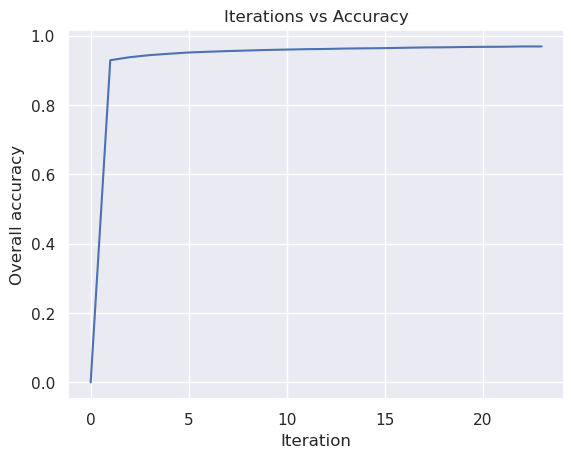

In [22]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [23]:
OUTS = f"""{datetime.now(timezone.utc).strftime("%Y_%m_%dT%H_%M")}_L001Trained_cylinder_RF.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_11_05T04_54_L001Trained_cylinder_RF.joblib']